In [0]:
!pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 43.2MB/s 
     |████████████████████████████████| 3.8MB 54.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255 * 2 - 1, x_test / 255 * 2 - 1
print("x_train.shape:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [0]:
#Aplanar los datos en un vector 

N, H, W = x_train.shape

D = H * W

x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)


In [0]:
#Dimensionalidad del espacio latente

latent_dim = 100

In [0]:
#Modelo generador

def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [0]:
#Modelo discriminador

def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model


In [0]:
#Compilacion  y preparacion de los dos modelos para el entrenamiento

discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

generator = build_generator(latent_dim)

#Entrada que representa la muestra de ruido desde el espacio latente
z = Input(shape=(latent_dim,))

#Introduce ruido a travez del generador para obtener una imagen
img = generator(z)

#Solo el generador es entrenado
discriminator.trainable = False

#La salida real es falsa, pero la etiquetamos como real!
fake_pred = discriminator(img)

#Creamos el modelo combinado
combined_model = Model(z, fake_pred)

#Compilamos el modelo combinado
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [0]:
#Entrenamiento de la GAN

batch_size = 32
epochs = 30000
sample_period = 200 #Cada "sample period" epocas se salvara informacion

#Se crea las etiquetas que se usaran cuando se llamen train_on_batch

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

#Se almacenan las perdidas

d_losses = []
g_losses = []

#Se almacenan las imagenes generadas
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

#Una funcion para generar una malla de valores rando desde el generador
#y salvarlos como un archivo

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  #Reescalado de imagenes 0-1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1

  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [0]:
#Ciclo de entrenamiento principal

for epoch in range(epochs):

  #Entrenamiento de discriminador

  #Selecionar un lote random de imagenes
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  #Generar las imagenes falsas
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  #Entrenar el discriminador
  #perdidad y precision son retornadas
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  #Entrenamiento de generador

  noise = np.random.rand(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  #Salvar las perdidas
  d_losses.append(d_loss)
  g_losses.append(g_losses)

  if epoch % 100 == 0:

    print(f"epoch: {epoch + 1 }/´{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
      sample_images(epoch)

      

epoch: 1/´30000, d_loss: 0.94, d_acc: 0.14, g_loss: 0.59
epoch: 101/´30000, d_loss: 0.00, d_acc: 1.00, g_loss: 0.11
epoch: 201/´30000, d_loss: 0.00, d_acc: 1.00, g_loss: 0.09
epoch: 301/´30000, d_loss: 0.01, d_acc: 1.00, g_loss: 0.48
epoch: 401/´30000, d_loss: 0.02, d_acc: 1.00, g_loss: 0.92
epoch: 501/´30000, d_loss: 0.01, d_acc: 1.00, g_loss: 0.61
epoch: 601/´30000, d_loss: 0.02, d_acc: 1.00, g_loss: 0.61
epoch: 701/´30000, d_loss: 0.01, d_acc: 1.00, g_loss: 0.90
epoch: 801/´30000, d_loss: 0.07, d_acc: 1.00, g_loss: 1.22
epoch: 901/´30000, d_loss: 0.50, d_acc: 0.77, g_loss: 0.25
epoch: 1001/´30000, d_loss: 0.10, d_acc: 1.00, g_loss: 0.36
epoch: 1101/´30000, d_loss: 0.10, d_acc: 0.98, g_loss: 0.27
epoch: 1201/´30000, d_loss: 0.22, d_acc: 0.92, g_loss: 0.08
epoch: 1301/´30000, d_loss: 0.30, d_acc: 0.91, g_loss: 0.18
epoch: 1401/´30000, d_loss: 0.13, d_acc: 0.98, g_loss: 0.04
epoch: 1501/´30000, d_loss: 0.45, d_acc: 0.78, g_loss: 0.39
epoch: 1601/´30000, d_loss: 0.07, d_acc: 1.00, g_los

In [0]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()


In [1]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

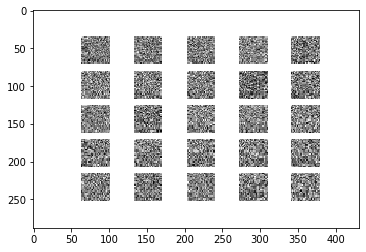

In [4]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)


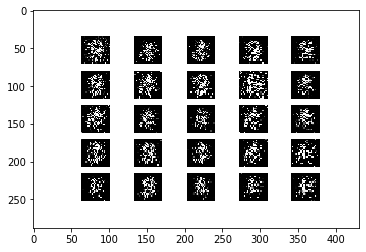

In [5]:
a = imread('gan_images/1000.png')
plt.imshow(a)

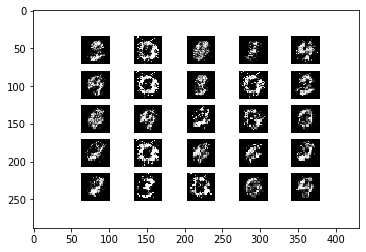

In [6]:
a = imread('gan_images/5000.png')
plt.imshow(a)

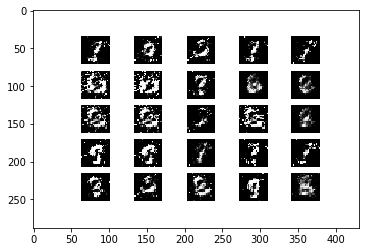

In [7]:
a = imread('gan_images/10000.png')
plt.imshow(a)

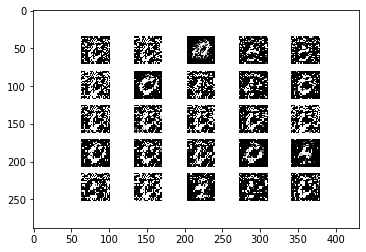

In [8]:
a = imread('gan_images/20000.png')
plt.imshow(a)

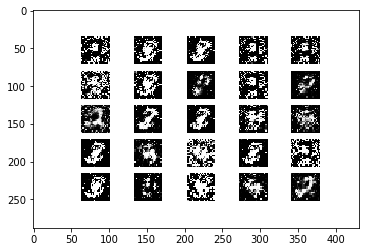

In [9]:
a = imread('gan_images/29800.png')
plt.imshow(a)